## Visualizar efectos de las distintas métricas de polígonos


In [ ]:
from main import *
import os
import cv2
import numpy as np
from cv2.typing import MatLike
from numpy.typing import NDArray
from typing import List, Dict, Tuple

# Definir colores
INVALID_COLOR = (128, 128, 128)  # Gris para métricas inválidas
ROJO = (0, 0, 255)
AZUL = (255, 0, 0)
AMARILLO = (0, 255, 255)
VERDE = (0, 255, 0)
MAGENTA = (255, 0, 255)
NEGRO = (0, 0, 0)
BLANCO = (255, 255, 255)
NARANJA = (0, 165, 255)

def get_color_by_metric(metric: float, metric_name: str):
    """
    Asigna un color basado en el valor de la métrica y su nombre.

    Args:
        metric (float): Valor de la métrica.
        metric_name (str): Nombre de la métrica ('area', 'perimeter', etc.).

    Returns:
        tuple: Color en formato (B, G, R).
    """
    if metric_name == "area":
        if metric is None or metric <= 0:
            return INVALID_COLOR
        if metric < 3950:
            return ROJO
        elif metric < 6500:
            return AMARILLO
        else:
            return AZUL
    elif metric_name == "perimeter":
        if metric is None or metric <= 0:
            return INVALID_COLOR
        if metric < 400:
            return ROJO
        elif metric < 550:
            return AMARILLO
        else:
            return AZUL
    elif metric_name == "aspect_ratio":
        if metric is None or metric <= 0 or metric == float("inf"):
            return INVALID_COLOR
        if metric < 1 / 4 or metric > 4:
            return ROJO
        elif metric < 1 / 2 or metric > 2:
            return AMARILLO
        else:
            return AZUL
    elif metric_name == "circularity":
        if metric is None or metric <= 0 or metric > 1:
            return INVALID_COLOR
        if metric <= 0.25:
            return ROJO
        elif 0.25 < metric <= 0.3:
            return AMARILLO
        elif 0.3 < metric <= 0.5:
            return AZUL
        elif 0.5 < metric <= 0.7:
            return VERDE
        else:
            return ROJO
    elif metric_name == "compactness":
        if metric is None or metric <= 0 or metric > 1:
            return INVALID_COLOR
        if metric <= 0.25 / (4 * np.pi):
            return ROJO
        elif 0.25 / (4 * np.pi) < metric <= 0.3 / (4 * np.pi):
            return AMARILLO
        elif 0.3 / (4 * np.pi) < metric <= 0.5 / (4 * np.pi):
            return AZUL
        elif 0.5 / (4 * np.pi) < metric <= 0.7 / (4 * np.pi):
            return VERDE
        else:
            return ROJO
    elif metric_name == "eccentricity":
        if metric is None or metric < 0:
            return INVALID_COLOR
        if metric > 0.9:
            return ROJO
        elif metric > 0.5:
            return AMARILLO
        else:
            return AZUL
    elif metric_name == "elongation":
        if metric is None or metric < 0 or 1 < metric:
            return INVALID_COLOR
        if metric <= 0.2:
            return ROJO
        elif 0.2 < metric <= 0.4:
            return VERDE
        elif 0.4 < metric <= 0.85:
            return AZUL
        elif 0.85 < metric <= 0.9:
            return AMARILLO
        else:
            return ROJO
    elif metric_name == "rectangularity":
        if metric is None or metric < 0 or 1 < metric:
            return INVALID_COLOR
        if metric <= 0.45:
            return ROJO
        elif 0.45 < metric <= 0.5:
            return AMARILLO
        elif 0.5 < metric <= 0.65:
            return AZUL
        elif 0.65 < metric <= 0.85:
            return VERDE
        else:
            return ROJO
    elif metric_name == "nitidez":
        if metric is None:
            return INVALID_COLOR
        elif metric <= 1.0:
            return ROJO
        elif 1.0 < metric <= 1.35:
            return AMARILLO
        elif 1.35 < metric <= 1.75:
            return AZUL
        elif 1.75 < metric <= 2:
            return VERDE
        else:
            return VERDE

    return INVALID_COLOR

def draw_segmentations(image: MatLike, segmentations: List[Dict[str, int | NDArray[np.float32]]],
                       img_width: int, img_height: int, metric_name: str, metrics_list: list[str], alpha=0.35):
    """
    Dibuja segmentaciones en la imagen con colores y texto según la métrica especificada.
    Para la métrica 'nitidez', solo dibuja el borde del polígono. Para otras métricas, rellena la máscara y dibuja el borde.

    Args:
        image: Imagen original.
        segmentations: Lista de segmentaciones.
        img_height, img_width: Dimensiones de la imagen.
        metric_name: Nombre de la métrica a usar.
        metrics_list: Lista de diccionarios con métricas precalculadas.
        alpha: Transparencia de la superposición.
    """
    overlay = image.copy()
    segmentations_info = []

    for seg, metrics in zip(segmentations, metrics_list):
        points = seg["points"]
        polygon = scale_polygon(points, img_width, img_height)

        metric = metrics[metric_name]
        color = get_color_by_metric(metric, metric_name)

        if metric_name == "nitidez":
            # Solo dibujar el borde para la métrica 'nitidez'
            cv2.polylines(overlay, [polygon], isClosed=True, color=color, thickness=2)
        else:
            # Rellenar el polígono y luego dibujar el borde para otras métricas
            cv2.fillPoly(overlay, [polygon], color)
            cv2.polylines(overlay, [polygon], isClosed=True, color=(0, 0, 0), thickness=2)

        # Calcular el centroide para mostrar el texto
        M = cv2.moments(polygon)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            segmentations_info.append((cx, cy, metric))
        else:
            print("Advertencia: Polígono con área cero.")

    # Combinar la imagen original con la capa superpuesta
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    # Dibujar el texto sobre la imagen combinada
    for cx, cy, metric in segmentations_info:
        if metric_name in ["area", "perimeter"]:
            metric_str = str(int(metric))
        else:
            metric_str = f"{metric:.4f}"
        cv2.putText(image, metric_str, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2,)

# Definir rutas base
base_dir = "salmones/"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

# Lista de métricas
metric_name_list = ["area", "perimeter", "aspect_ratio", "rectangularity", "eccentricity", "elongation", "circularity", "nitidez"]
subfolders = ["test", "train", "valid"]
img_height, img_width = 640, 640
# Procesar imágenes
for sub in subfolders:
    img_subdir = os.path.join(images_dir, sub)
    label_subdir = os.path.join(labels_dir, sub)

    img_files = [f for f in os.listdir(img_subdir) if f.endswith((".jpg", ".jpeg", ".png"))]

    for img_file in img_files:
        img_path = os.path.join(img_subdir, img_file)
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(label_subdir, label_file)

        if not os.path.exists(label_path):
            continue
        image = cv2.imread(img_path)
        if image is None:
            continue
        #img_height, img_width = image.shape[:2]
        segmentations_of_file = load_yolo_segmentation(label_path)

        if image is not None:
            # Convertir la imagen a escala de grises
            gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Calcular gradiente y laplaciano de la imagen
            sob_kernel = get_sobel_kernel(-1)
            sob_factor = calcular_escala_kernel(sob_kernel)
            gx = cv2.Sobel(gris, cv2.CV_32F, 1, 0, ksize=-1, scale=sob_factor)
            gy = cv2.Sobel(gris, cv2.CV_32F, 0, 1, ksize=-1, scale=sob_factor)
            grad_mag = np.sqrt(gx**2 + gy**2)
            laplaciano = cv2.Laplacian(gris, cv2.CV_32F)
            gradientes = grad_mag, laplaciano
        else:
            gradientes = None

        metrics_list = []
        # Calcular métricas para cada imagen
        for seg in segmentations_of_file:
            points = seg['points']
            polygon = scale_polygon(points, img_width, img_height)
            metrics = calc_metrics_single_polygon(polygon, metric_name_list, 0.3, 5, gradientes)
            metrics_list.append(metrics)

        # Generar imagen para cada métrica
        for metric_name in metric_name_list:
            segmented_dir = os.path.join(base_dir, f"metric_{metric_name}", sub)
            os.makedirs(segmented_dir, exist_ok=True)
            segmented_img_path = os.path.join(segmented_dir, img_file)
            image_copy = image.copy()
            draw_segmentations(image_copy, segmentations_of_file, img_width, img_height, metric_name, metrics_list,)
            cv2.imwrite(segmented_img_path, image_copy)

## Distribución de la nitidez del dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def construir_dataframe(datos):
    """Convierte la lista de diccionarios en un DataFrame plano."""
    nitidez_borde = []
    nitidez_interior = []
    archivos = []

    for entrada in datos:
        archivo = entrada["archivo"]
        for borde, interior in entrada["lista_nitidez"]:
            nitidez_borde.append(borde)
            nitidez_interior.append(interior)
            archivos.append(archivo)

    df = pd.DataFrame({
        "nitidez_borde": nitidez_borde,
        "nitidez_interior": nitidez_interior,
        "archivo": archivos
    })
    return df

def calcular_promedio_ponderado(df, peso_borde=0.5, peso_interior=0.5, log_scale=False):
    """Agrega una columna de promedio ponderado al DataFrame."""
    if log_scale:
        df["promedio"] = np.log1p(np.power(df["nitidez_borde"], peso_borde) * np.power(df["nitidez_interior"], peso_interior))
    else:
        df["promedio"] = df["nitidez_borde"] * peso_borde + df["nitidez_interior"] * peso_interior
    return df

def agrupar_por_bins(df, num_bins, log_scale=False):
    """Agrupa datos ordenados por promedio en bins para análisis comparativo."""
    df_sorted = df.sort_values("promedio").reset_index(drop=True)
    bin_size = len(df_sorted) // num_bins

    borde_means, interior_means, promedio_bin = [], [], []

    for i in range(num_bins):
        bin_df = df_sorted.iloc[i * bin_size: (i + 1) * bin_size]
        if bin_df.empty:
            continue
        if log_scale:
            borde_means.append(np.mean(np.log1p(bin_df["nitidez_borde"])))
            interior_means.append(np.mean(np.log1p(bin_df["nitidez_interior"])))
            promedio_bin.append(bin_df["promedio"].mean())
        else:
            borde_means.append(bin_df["nitidez_borde"].mean())
            interior_means.append(bin_df["nitidez_interior"].mean())
            promedio_bin.append(bin_df["promedio"].mean())

    return promedio_bin, borde_means, interior_means

def plot_datos(df, promedio_bin, borde_means, interior_means, num_bins, factor_borde, factor_interior, log_scale=False):
    """Grafica la distribución y la comparación de nitidez, con percentiles 30/70 sombreados."""
    # Histogram data
    counts, bin_edges = np.histogram(df["promedio"], bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    log_text = " log1p " if log_scale else " "

    # Cálculo de percentiles
    p30 = np.percentile(df["promedio"], 30)
    p70 = np.percentile(df["promedio"], 70)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # --- Subplot 1: Distribución del promedio con percentiles ---
    ax1.scatter(bin_centers, counts, color='darkcyan', s=40, alpha=0.7)
    ax1.plot(bin_centers, counts, color='darkcyan', alpha=0.5)

    # Sombreado
    ymin, ymax = ax1.get_ylim()
    ax1.axvspan(bin_edges[0], p30, facecolor='red', alpha=0.1, label='Peor 30 %')
    ax1.axvspan(p30, p70, facecolor='yellow', alpha=0.1, label='30 - 70 %')
    ax1.axvspan(p70, bin_edges[-1], facecolor='green', alpha=0.05, label='Mejor 30 %')

    # Líneas de percentil
    ax1.axvline(p30, color='red', linestyle='--', label='30° percentil')
    ax1.axvline(p70, color='green', linestyle='--', label='70° percentil')

    ax1.set_title(fr"Distribución de la Nitidez Promedio{log_text}($bor=${factor_borde}, $int=${factor_interior})")
    ax1.set_xlabel("Nitidez Promedio Ponderado")
    ax1.set_ylabel("Frecuencia")
    ax1.legend()
    ax1.grid(True)

    # --- Subplot 2: Comparación Borde vs Interior ---
    for x, b, i in zip(promedio_bin, borde_means, interior_means):
        color = 'green' if b > i else 'red'
        ax2.plot([x, x], [b, i], color=color, linewidth=2)

    ax2.scatter(promedio_bin, borde_means, label='Nitidez Borde', color='blue')
    ax2.scatter(promedio_bin, interior_means, label='Nitidez Interior', color='orange')

    mean_line = [(b + i) / 2 for b, i in zip(borde_means, interior_means)]
    ax2.plot(promedio_bin, mean_line, label='Promedio (Borde + Interior)', color='black', linestyle='--')

    ax2.set_title("Comparación de Nitidez Borde e Interior (agrupado por promedio)")
    ax2.set_xlabel("Nitidez Promedio Ponderado")
    ax2.set_ylabel("Valor de nitidez")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def analizar_nitidez_total(list_nitidez_total, df=None, peso_borde=0.7, peso_interior=0.3, num_bins=200, log_scale=False):
    """Pipeline completo del análisis de nitidez."""
    df = construir_dataframe(list_nitidez_total) if df is None else df
    df = calcular_promedio_ponderado(df, peso_borde, peso_interior, log_scale)
    promedio_bin, borde_means, interior_means = agrupar_por_bins(df, num_bins, log_scale)
    plot_datos(df, promedio_bin, borde_means, interior_means, num_bins, peso_borde, peso_interior, log_scale)
    return df  # por si se quiere guardar o analizar

In [4]:
# Guardar las nitideces para poder usarlas luego
#df = construir_dataframe(list_nitidez_total)
#df.to_csv("nitidez_por_imagen.csv")

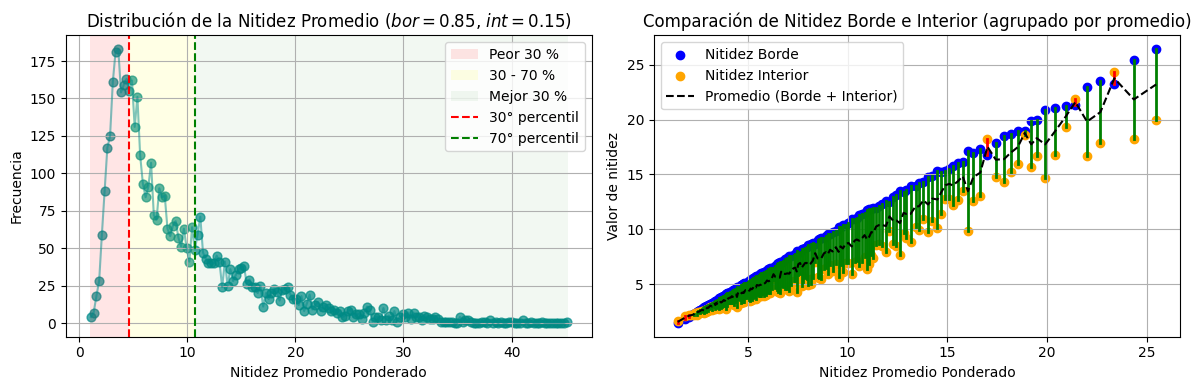

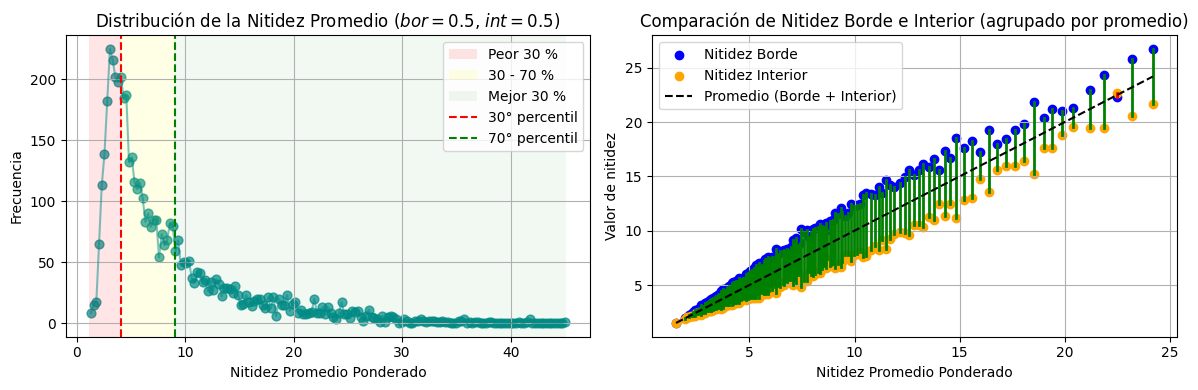

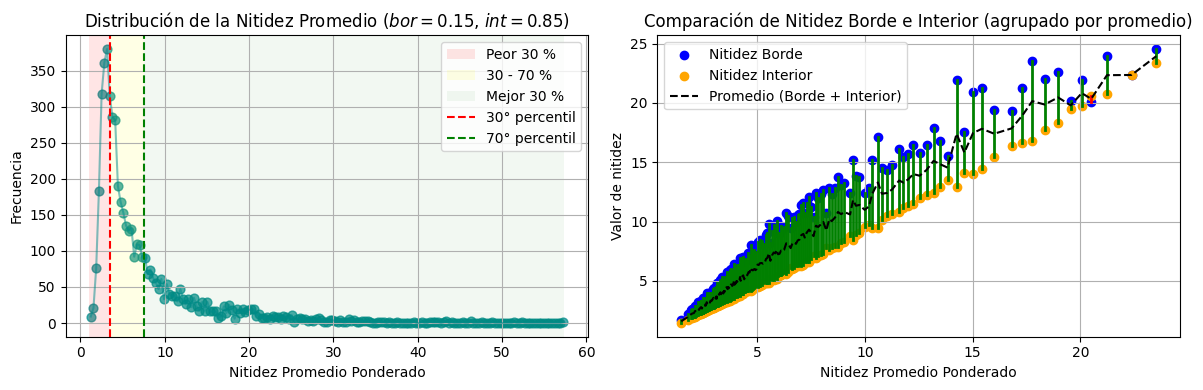

In [5]:
# Cargar los datos de nitidez para estudiarlos
df = pd.read_csv("nitidez_por_imagen.csv")
list_nitidez_total = None

df_resultado0 = analizar_nitidez_total(list_nitidez_total, df, peso_borde=0.85, peso_interior=0.15, num_bins=175, log_scale=False)
df_resultado1 = analizar_nitidez_total(list_nitidez_total, df, peso_borde=0.5, peso_interior=0.5, num_bins=175, log_scale=False)
df_resultado2 = analizar_nitidez_total(list_nitidez_total, df, peso_borde=0.15, peso_interior=0.85, num_bins=175, log_scale=False)

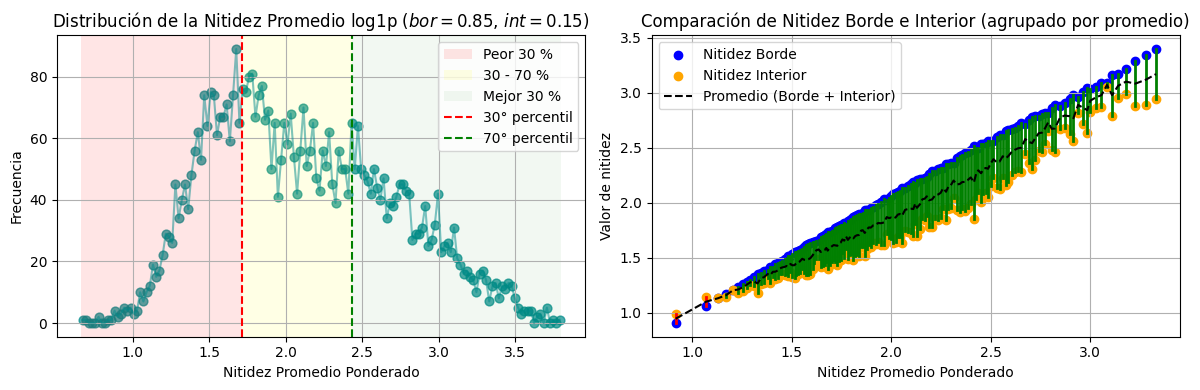

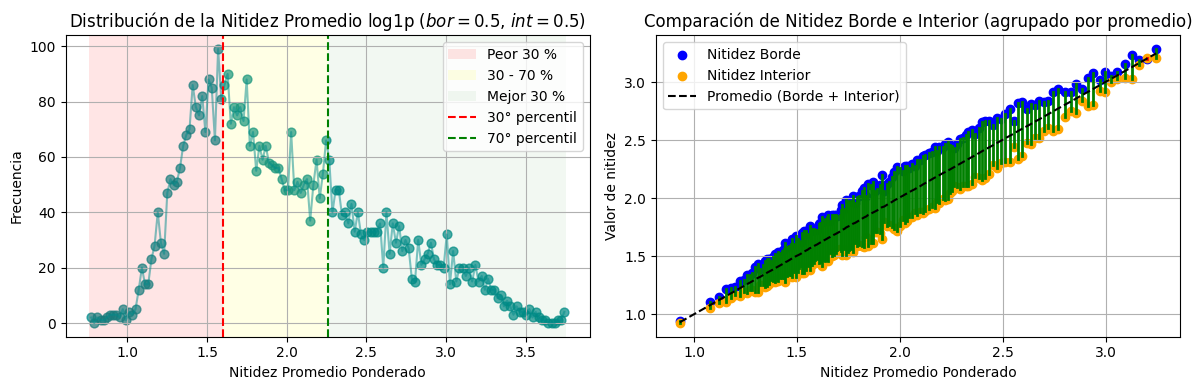

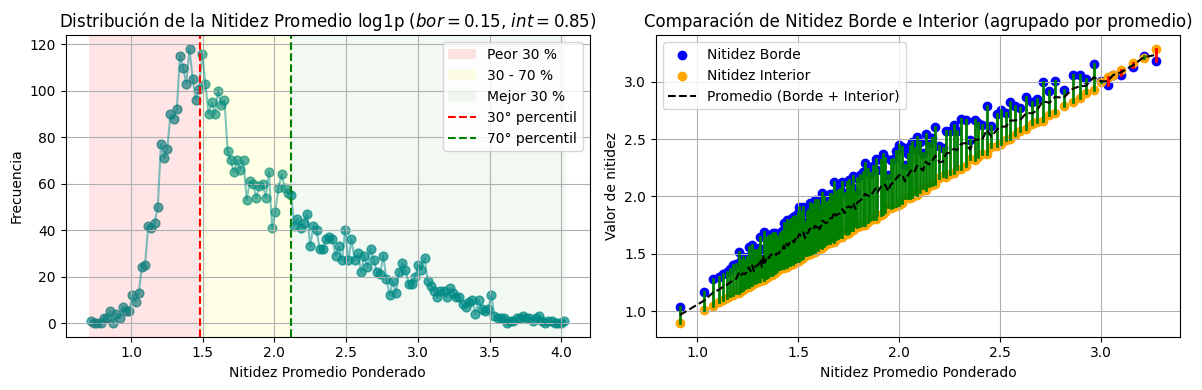

In [6]:
# Cargar los datos de nitidez para estudiarlos
df = pd.read_csv("nitidez_por_imagen.csv")
list_nitidez_total = None

df_resultado3 = analizar_nitidez_total(list_nitidez_total, df, peso_borde=0.85, peso_interior=0.15, num_bins=150, log_scale=True)
df_resultado4 = analizar_nitidez_total(list_nitidez_total, df, peso_borde=0.5, peso_interior=0.5, num_bins=150, log_scale=True)
df_resultado5 = analizar_nitidez_total(list_nitidez_total, df, peso_borde=0.15, peso_interior=0.85, num_bins=150, log_scale=True)

In [7]:
import os
import pickle

image_list = set()
casos0 = df_resultado0.sort_values("promedio", ascending=False).head(2)["archivo"]
casos1 = df_resultado0.sort_values("promedio", ascending=True).head(7)["archivo"]
casos2 = df_resultado3.sort_values("promedio", ascending=False).head(2)["archivo"]
casos3 = df_resultado3.sort_values("promedio", ascending=True).head(7)["archivo"]
casos4 = df_resultado5.sort_values("promedio", ascending=False).head(2)["archivo"]
casos5 = df_resultado5.sort_values("promedio", ascending=True).head(7)["archivo"]

image_list.update(os.path.join(caso.split("/")[2], os.path.splitext(caso.split("/")[3])[0] + ".jpg") for caso in casos0)
image_list.update(os.path.join(caso.split("/")[2], os.path.splitext(caso.split("/")[3])[0] + ".jpg") for caso in casos1)
image_list.update(os.path.join(caso.split("/")[2], os.path.splitext(caso.split("/")[3])[0] + ".jpg") for caso in casos2)
image_list.update(os.path.join(caso.split("/")[2], os.path.splitext(caso.split("/")[3])[0] + ".jpg") for caso in casos3)
image_list.update(os.path.join(caso.split("/")[2], os.path.splitext(caso.split("/")[3])[0] + ".jpg") for caso in casos4)
image_list.update(os.path.join(caso.split("/")[2], os.path.splitext(caso.split("/")[3])[0] + ".jpg") for caso in casos5)

# Guardar los mejores y peores casos para 2 tipos de ponderación. Estas imagenes serviran de buenos ejemplos
with open("list_imagenes_ejemplo.pkl", "wb") as f:
    pickle.dump(image_list, f)

## Test Elongation metric distributions

La idea es testear si es más conveniente representar la "elongación" como simplemente E, 1/E o (E-1)/(E+1).

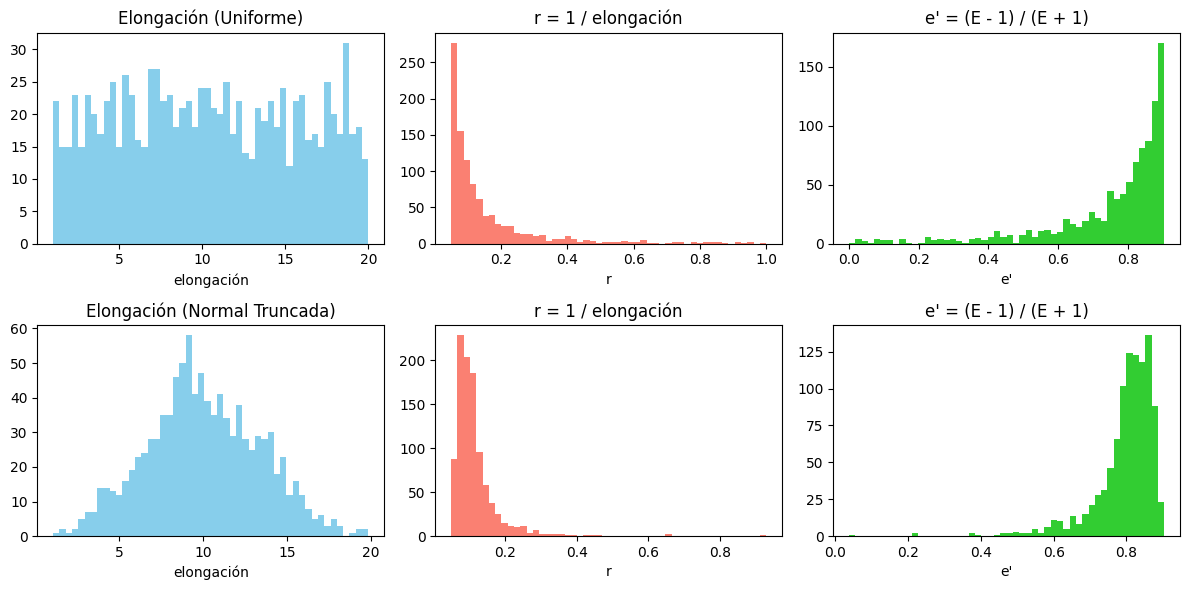

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

def generate_data(generator, size=1000, **kwargs):
    data = generator(size=size, **kwargs)
    return data, 1 / data, (data - 1) / (data + 1)

uniform_gen = lambda size: np.random.uniform(1, 20, size)
truncnorm_gen = lambda size: truncnorm.rvs((1-10)/3.5, (20-10)/3.5, loc=10, scale=3.5, size=size)

uni_data = generate_data(uniform_gen)
trunc_data = generate_data(truncnorm_gen)

plt.figure(figsize=(12, 6))
for i, (data, title, color, xlabel) in enumerate(zip([*uni_data, *trunc_data], 
    ["Elongación (Uniforme)", "r = 1 / elongación", "e' = (E - 1) / (E + 1)", 
     "Elongación (Normal Truncada)", "r = 1 / elongación", "e' = (E - 1) / (E + 1)"],
    ["skyblue", "salmon", "limegreen"] * 2, ["elongación", "r", "e'"] * 2), 1):
    plt.subplot(2, 3, i)
    plt.hist(data, bins=50, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
plt.tight_layout()
plt.savefig('histograms.png')

## Testear distribuciones de varianzas

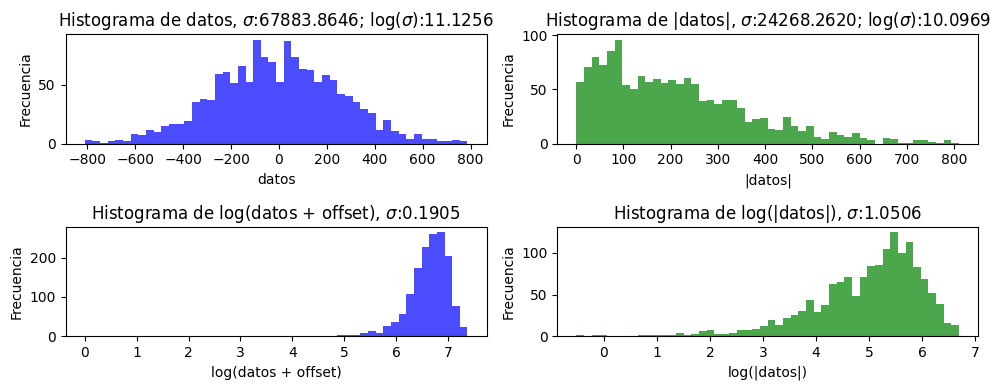

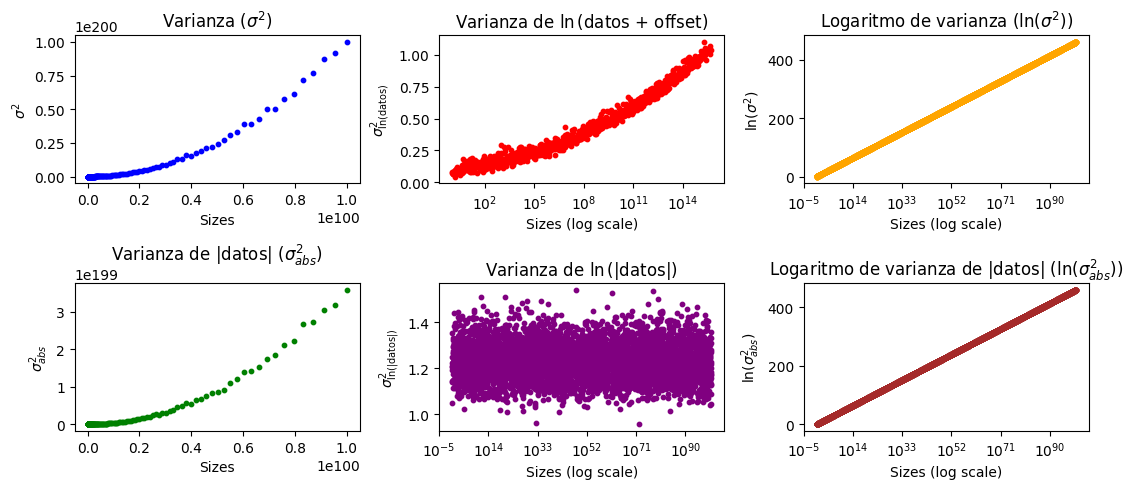

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import numba

# --- Auxiliary Functions ---
@numba.jit(nopython=True)
def calcular_varianza(datos):
    """
    Calcula la varianza de un arreglo.
    
    Args:
        datos (np.ndarray): Arreglo 1D de datos (float64).
    
    Returns:
        float: Varianza.
    """
    n = len(datos)
    if n == 0:
        return 0.0
    media = np.mean(datos)  # Usar NumPy para la media
    suma_cuadrados = 0.0
    for i in range(n):
        suma_cuadrados += (datos[i] - media) ** 2
    return suma_cuadrados / n

@numba.jit(nopython=True)
def calcular_logaritmos(datos, offset):
    """
    Aplica el logaritmo natural a los datos con un desplazamiento.
    
    Args:
        datos (np.ndarray): Arreglo 1D de datos (float64).
        offset (float): Desplazamiento para evitar log(0).
    
    Returns:
        np.ndarray: Arreglo con log(datos + offset).
    """
    return np.log(datos + offset)  # Vectorización con NumPy

@numba.jit(nopython=True)
def obtener_offset(datos, size, normal):
    """
    Determina el desplazamiento para los logaritmos.
    
    Args:
        datos (np.ndarray): Arreglo 1D de datos (float64).
        size (float): Valor de desplazamiento si normal=False.
        normal (bool): Si True, usa el mínimo absoluto + 1.
    
    Returns:
        float: Desplazamiento.
    """
    if not normal:
        return size + 1.0
    return abs(np.min(datos)) + 1.0  # Usar NumPy para el mínimo

# --- Core Calculation Function ---
@numba.jit(nopython=True)
def calcular_varianzas(datos, size, normal=False):
    """
    Calcula varianzas y logaritmos de un conjunto de datos.
    
    Args:
        datos (np.ndarray): Arreglo 1D de datos (float64).
        size (float): Valor para el desplazamiento si normal=False.
        normal (bool): Si True, usa el mínimo absoluto + 1 como desplazamiento.
    
    Returns:
        tuple: (var, var_abs, var_log_datos, var_log_datos_abs, log_var_datos, log_var_datos_abs)
    """
    if len(datos) == 0:
        return 0.0, 0.0, 0.0, 0.0, -np.inf, -np.inf
    
    datos_abs = np.abs(datos)  # Vectorización para valores absolutos
    var = calcular_varianza(datos)
    var_abs = calcular_varianza(datos_abs)
    
    offset = obtener_offset(datos, size, normal)
    log_datos = calcular_logaritmos(datos, offset)
    log_datos_abs = calcular_logaritmos(datos_abs, 0)
    
    var_log_datos = calcular_varianza(log_datos)
    var_log_datos_abs = calcular_varianza(log_datos_abs)
    
    log_var_datos = np.log(var) if var > 0 else -np.inf  # Manejo de log(0)
    log_var_datos_abs = np.log(var_abs) if var_abs > 0 else -np.inf
    
    return var, var_abs, var_log_datos, var_log_datos_abs, log_var_datos, log_var_datos_abs

# --- Processing Helper ---
@numba.jit(nopython=True)
def _procesar_columnas(datos, sizes, normal, var_list, var_abs_list, var_log_datos_list, var_log_datos_abs_list, log_var_datos_list, log_var_datos_abs_list):
    """
    Procesa las columnas de datos y llena los arreglos de resultados.
    
    Args:
        datos (np.ndarray): Arreglo de forma (N, M).
        sizes (np.ndarray): Arreglo de forma (M,).
        normal (bool): Si True, usa el mínimo absoluto + 1 como desplazamiento.
        var_list, var_abs_list, ...: Arreglos preasignados para resultados.
    """
    M = datos.shape[1]
    for j in range(M):
        columna = datos[:, j]
        var, var_abs, var_log_datos, var_log_datos_abs, log_var_datos, log_var_datos_abs = \
            calcular_varianzas(columna, sizes[j], normal)
        var_list[j] = var
        var_abs_list[j] = var_abs
        var_log_datos_list[j] = var_log_datos
        var_log_datos_abs_list[j] = var_log_datos_abs
        log_var_datos_list[j] = log_var_datos
        log_var_datos_abs_list[j] = log_var_datos_abs

def comparar_log_varianza_muchos_casos(datos, sizes, normal=False):
    """
    Calcula métricas de varianza para múltiples conjuntos de datos y grafica contra sizes en escala logarítmica.
    
    Args:
        datos (np.ndarray): Arreglo de forma (N, M) con M conjuntos de datos de longitud N.
        sizes (np.ndarray): Arreglo de forma (M,) con un size para cada conjunto.
        normal (bool): Si True, usa el mínimo absoluto + 1 como desplazamiento.
    
    Returns:
        dict: Diccionario con arreglos de varianzas y logaritmos.
    """
    # Validar formas y valores de sizes
    if datos.shape[1] != len(sizes):
        raise ValueError("El número de columnas de datos debe coincidir con la longitud de sizes.")
    if np.any(sizes <= 0):
        raise ValueError("Los valores de sizes deben ser positivos para la escala logarítmica.")

    # Preasignar arreglos para resultados
    M = datos.shape[1]
    var_list = np.empty(M, dtype=np.float64)
    var_abs_list = np.empty(M, dtype=np.float64)
    var_log_datos_list = np.empty(M, dtype=np.float64)
    var_log_datos_abs_list = np.empty(M, dtype=np.float64)
    log_var_datos_list = np.empty(M, dtype=np.float64)
    log_var_datos_abs_list = np.empty(M, dtype=np.float64)

    # Procesar columnas con Numba
    _procesar_columnas(datos, sizes, normal, var_list, var_abs_list, var_log_datos_list, var_log_datos_abs_list, log_var_datos_list, log_var_datos_abs_list)

    # Definir parámetros de los subplots en una lista de diccionarios
    plots_params = [
        {'data': var_list, 'color': 'blue', 'title': r'Varianza ($\sigma^2$)', 'ylabel': r'$\sigma^2$'},
        {'data': var_log_datos_list, 'color': 'red', 'title': r'Varianza de $\ln$(datos + offset)', 'ylabel': r'$\sigma^2_{\ln(\text{datos})}$'},
        {'data': log_var_datos_list, 'color': 'orange', 'title': r'Logaritmo de varianza ($\ln(\sigma^2)$)', 'ylabel': r'$\ln(\sigma^2)$'},
        {'data': var_abs_list, 'color': 'green', 'title': r'Varianza de |datos| ($\sigma^2_{abs}$)', 'ylabel': r'$\sigma^2_{abs}$'},
        {'data': var_log_datos_abs_list, 'color': 'purple', 'title': r'Varianza de $\ln$(|datos|)', 'ylabel': r'$\sigma^2_{\ln(|\text{datos}|)}$'},
        {'data': log_var_datos_abs_list, 'color': 'brown', 'title': r'Logaritmo de varianza de |datos| ($\ln(\sigma^2_{abs})$)', 'ylabel': r'$\ln(\sigma^2_{abs})$'}
    ]

    # Crear la figura
    plt.figure(figsize=(11, 5))

    # Iterar sobre los parámetros y crear cada subplot
    for i, params in enumerate(plots_params, start=1):
        plt.subplot(2, 3, i)
        plt.scatter(sizes, params['data'], color=params['color'], s=10)
        plt.title(params['title'])
        plt.ylabel(params['ylabel'])
        if i in [2, 3, 5, 6]:
            plt.xscale('log')
            plt.xlabel('Sizes (log scale)')
        else:
            plt.xlabel('Sizes')

    plt.tight_layout()
    plt.show()

def comparar_log_varianza_1_caso(datos, size, normal=False):
    """
    Calcula métricas de varianza para un conjunto de datos y grafica histogramas.
    
    Args:
        datos (np.ndarray): Arreglo 1D de datos.
        size (float): Valor para el desplazamiento si normal=False.
        normal (bool): Si True, usa el mínimo absoluto + 1 como desplazamiento.
    """
    datos_abs = np.abs(datos)
    var = np.var(datos)
    var_abs = np.var(datos_abs)
    offset = (np.abs(np.min(datos)) + 1) if normal else (size + 1)
    log_datos = np.log(datos + offset)
    log_datos_abs = np.log(datos_abs)
    
    var_log_datos = np.var(log_datos)
    var_log_datos_abs = np.var(log_datos_abs)
    log_var_datos = np.log(var) if var > 0 else -np.inf
    log_var_datos_abs = np.log(var_abs) if var_abs > 0 else -np.inf
    
    # Definir parámetros de los subplots en una lista de diccionarios
    plots_params = [
        {
            'data': datos,
            'color': 'blue',
            'title': fr"Histograma de datos, $\sigma$:{var:.4f}; log($\sigma$):{log_var_datos:.4f}",
            'xlabel': 'datos',
            'ylabel': 'Frecuencia'
        },
        {
            'data': datos_abs,
            'color': 'green',
            'title': fr"Histograma de |datos|, $\sigma$:{var_abs:.4f}; log($\sigma$):{log_var_datos_abs:.4f}",
            'xlabel': '|datos|',
            'ylabel': 'Frecuencia'
        },
        {
            'data': log_datos,
            'color': 'blue',
            'title': fr"Histograma de log(datos + offset), $\sigma$:{var_log_datos:.4f}",
            'xlabel': 'log(datos + offset)',
            'ylabel': 'Frecuencia'
        },
        {
            'data': log_datos_abs,
            'color': 'green',
            'title': fr"Histograma de log(|datos|), $\sigma$:{var_log_datos_abs:.4f}",
            'xlabel': 'log(|datos|)',
            'ylabel': 'Frecuencia'
        }
    ]

    # Crear la figura
    plt.figure(figsize=(10, 4))

    # Iterar sobre los parámetros y crear cada subplot
    for i, params in enumerate(plots_params, start=1):
        plt.subplot(2, 2, i)
        plt.hist(params['data'], bins=50, color=params['color'], alpha=0.7)
        plt.title(params['title'])
        plt.xlabel(params['xlabel'])
        plt.ylabel(params['ylabel'])

    plt.tight_layout()
    plt.show()

# Ejemplo
size = 255
lenght = 5000
sizes = np.logspace(start=0, stop=100, num=lenght, base=10, dtype=np.float64)
datos = np.random.randn(1500, lenght) * sizes
datos2 = (np.random.rand(1500, lenght)-0.5) * sizes

comparar_log_varianza_1_caso(datos[::,0]*size, size, True)
comparar_log_varianza_muchos_casos(datos, sizes, True)
# Varianza >> Varianza (datos_abs)
# Varianza log(datos) = Varianza log(datos_abs)
# Logaritmo var(datos) > Logaritmo var(datos_abs)

## Revisar Nitidez

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from main import load_yolo_segmentation, calcular_escala_kernel, get_sobel_kernel, scale_polygon

def compute_metrics(gris, segmentations, ksize1=-1, ksize2=None, ksize3=3):
    """
    Para cada polígono:
      - calcula nitidez_borde: media de grad_mag en una banda de grosor ksize alrededor del contorno
      - calcula nitidez_interior: varianza de laplaciano en el interior
    Devuelve:
      polygons: lista de np.int32 arrays de forma (n,1,2)
      bordes: lista de floats
      interiores: lista de floats
    """
    h, w = gris.shape
    # Factor de escala
    sob_kernel = get_sobel_kernel(ksize1)
    sob_factor = calcular_escala_kernel(sob_kernel)

    # Gradiente y Laplaciano
    gx = cv2.Sobel(gris, cv2.CV_32F, 1, 0, ksize=ksize1, scale=sob_factor)
    gy = cv2.Sobel(gris, cv2.CV_32F, 0, 1, ksize=ksize1, scale=sob_factor)
    lap = cv2.Laplacian(gris, cv2.CV_32F) if ksize2 is None else cv2.Laplacian(gris, cv2.CV_32F, ksize=ksize2)
    
    grad_mag = np.sqrt(gx**2 + gy**2)
    lap_db = lap

    # Kernel para dilatación (banda alrededor del contorno)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize3, ksize3))
    polygons = []
    nitidez_interna = []
    nitidez_borde = []
    band_bordes = []

    for seg in segmentations:
        # Escala puntos y forma polígono
        poly = scale_polygon(seg["points"], w, h)
        polygons.append(poly)

        # Máscara interior
        mask_int = np.zeros_like(gris, dtype=np.uint8)
        cv2.fillPoly(mask_int, [poly], 255)
        pix_int = lap_db[mask_int == 255]
        nit_int = np.std(pix_int)
        nitidez_interna.append(nit_int)

        # Máscara de contorno
        mask_edge = np.zeros_like(gris, dtype=np.uint8)
        cv2.drawContours(mask_edge, [poly], -1, 255, thickness=1)
        mask_band = cv2.dilate(mask_edge, kernel, iterations=1)
        pix_band = grad_mag[mask_band == 255]
        nit_borde = np.mean(pix_band)
        nitidez_borde.append(nit_borde)
        band_bordes.append(mask_band)

    return polygons, nitidez_interna, nitidez_borde, lap_db, grad_mag, band_bordes

def plot_results(image, polygons, nitidez_interna, nitidez_borde, lap_db, grad_mag, band_bordes, peso_borde, peso_interior):
    copy = image.copy()
    gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Máscaras para la versión mascarada
    mask_int = np.zeros_like(gris, dtype=np.uint8)
    grad_masked = np.zeros_like(grad_mag)
    for poly, band in zip(polygons, band_bordes):
        cv2.fillPoly(mask_int, [poly], 255)
        grad_masked[band== 255] = grad_mag[band == 255]

    lap_masked = np.zeros_like(lap_db)
    lap_masked[mask_int == 255] = np.abs(lap_db[mask_int == 255])

    # --- PLOT ---
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for poly in polygons:
        cv2.polylines(copy, [poly], isClosed=True, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    heatmap4 = axs[0].imshow(cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original (máscara)")
    axs[0].axis("off")
    #plt.colorbar(heatmap4, ax=axs[0])
    heatmap5 = axs[1].imshow(lap_masked, cmap="viridis")
    axs[1].set_title("Laplaciano (solo interior)")
    axs[1].axis("off")
    #plt.colorbar(heatmap5, ax=axs[1])
    heatmap6 = axs[2].imshow(grad_masked, cmap="viridis")
    axs[2].set_title("Gradiente (solo borde)")
    axs[2].axis("off")
    #plt.colorbar(heatmap6, ax=axs[2])

    # Anotar métricas en ambos casos
    for j, (poly, int_val, bord_val) in enumerate(zip(polygons, nitidez_interna, nitidez_borde)):
        promedio_ponderado = np.log1p(np.power(bord_val, peso_borde) * np.power(int_val, peso_interior))
        M = cv2.moments(poly)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            axs[0].text(cx, cy, f"{promedio_ponderado:.2f}", color="cyan", fontsize=8, ha="center", va="center")
            axs[1].text(cx, cy, f"{int_val:.2f}", color="cyan", fontsize=8, ha="center", va="center")
            axs[2].text(cx, cy, f"{bord_val:.2f}", color="cyan", fontsize=8, ha="center", va="center")

    plt.tight_layout()
    plt.show()

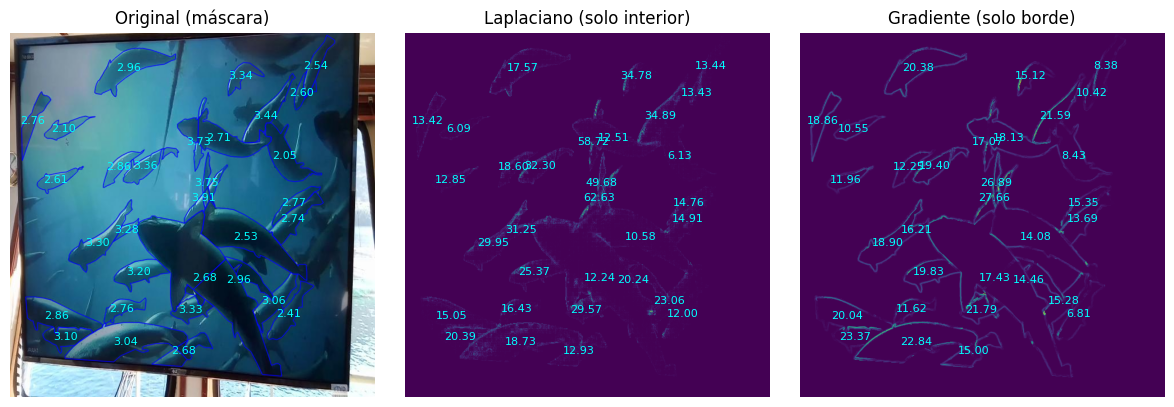

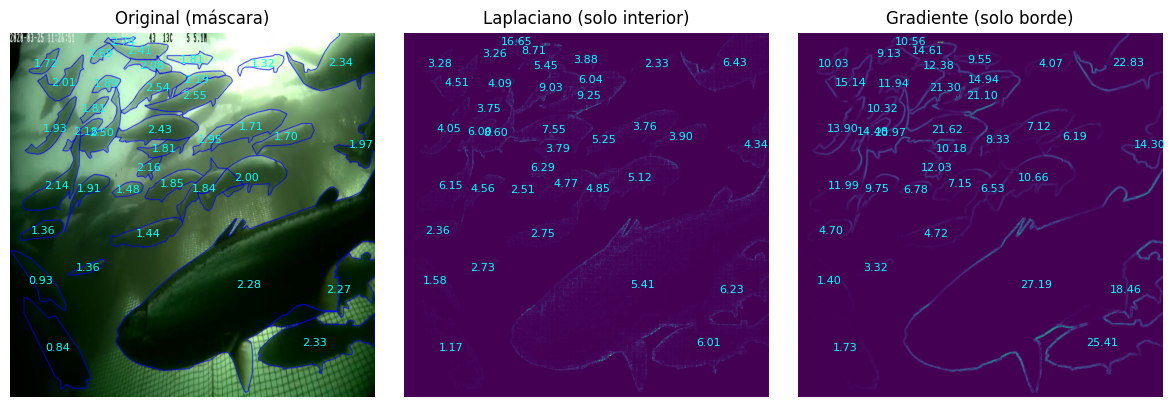

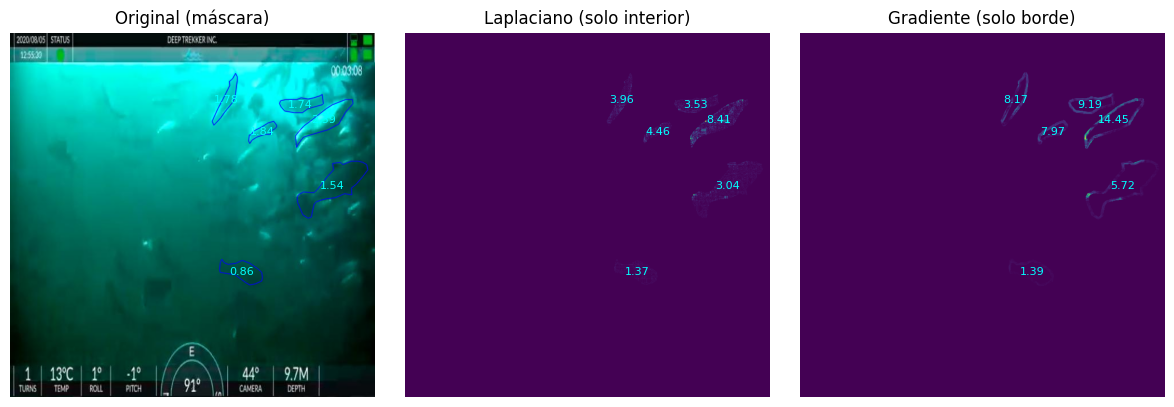

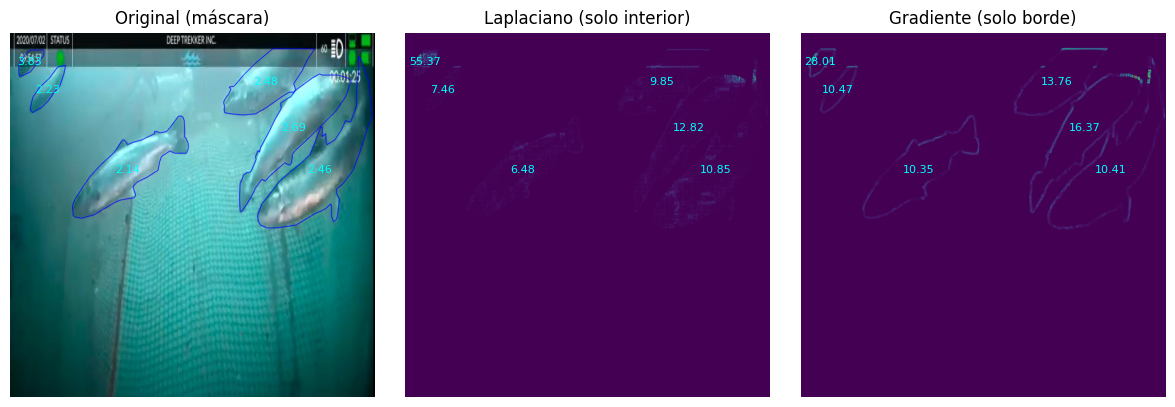

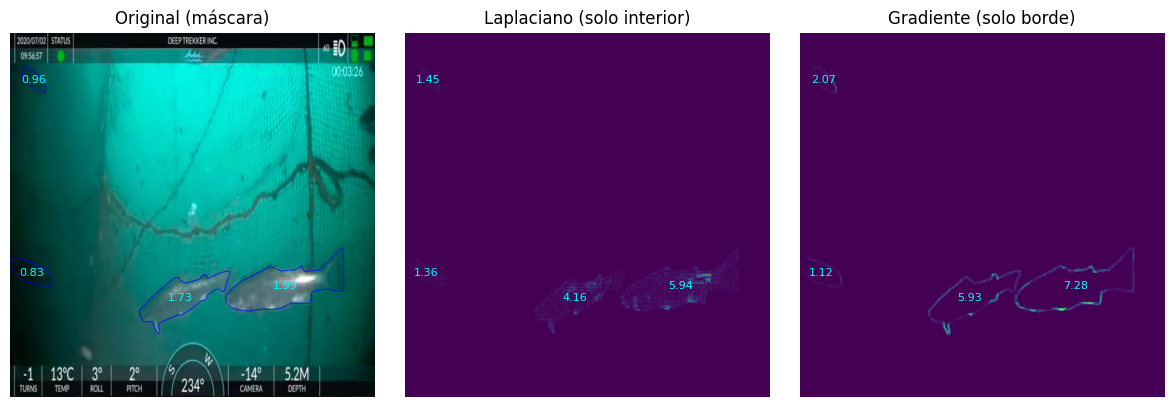

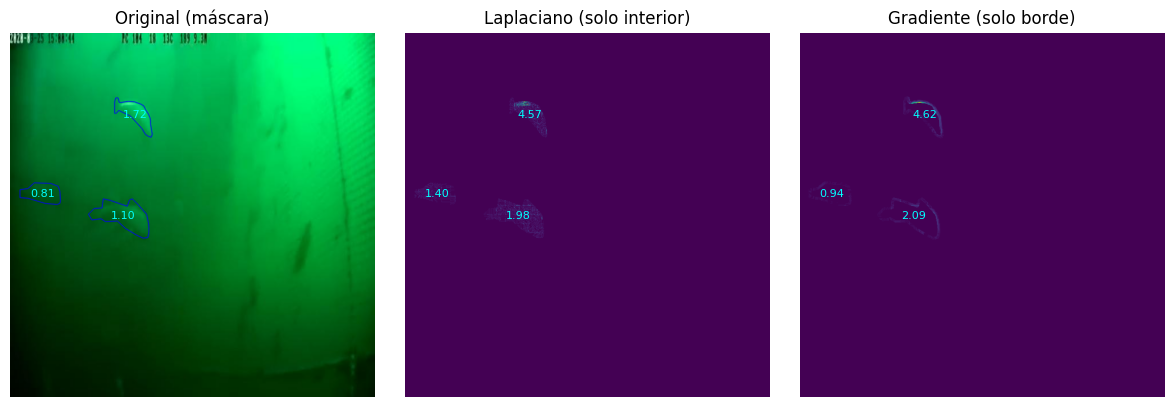

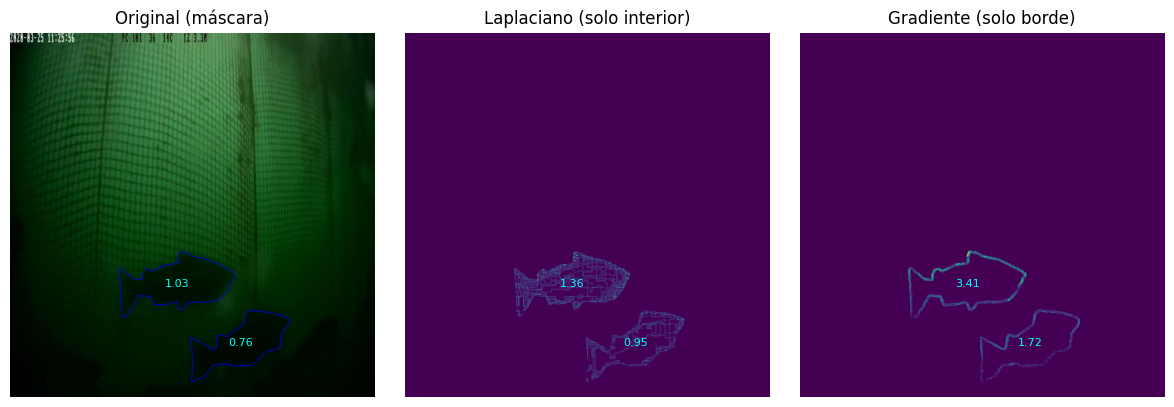

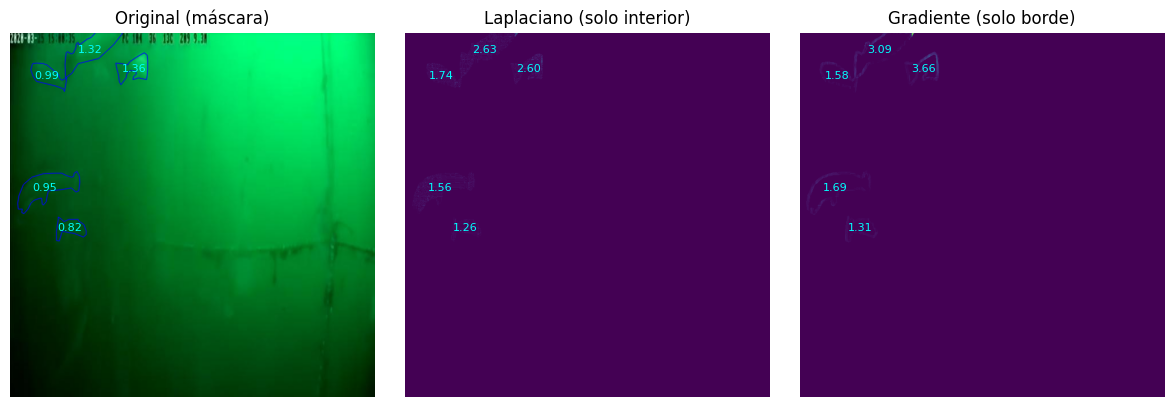

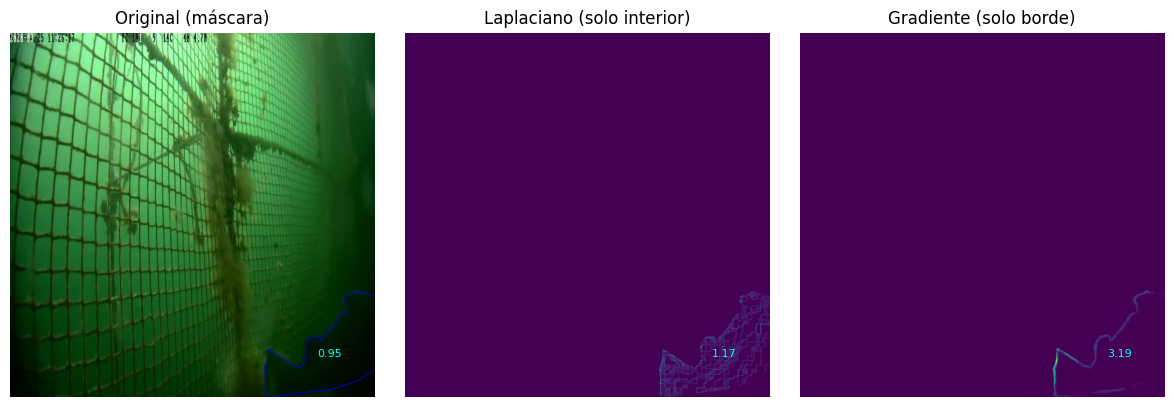

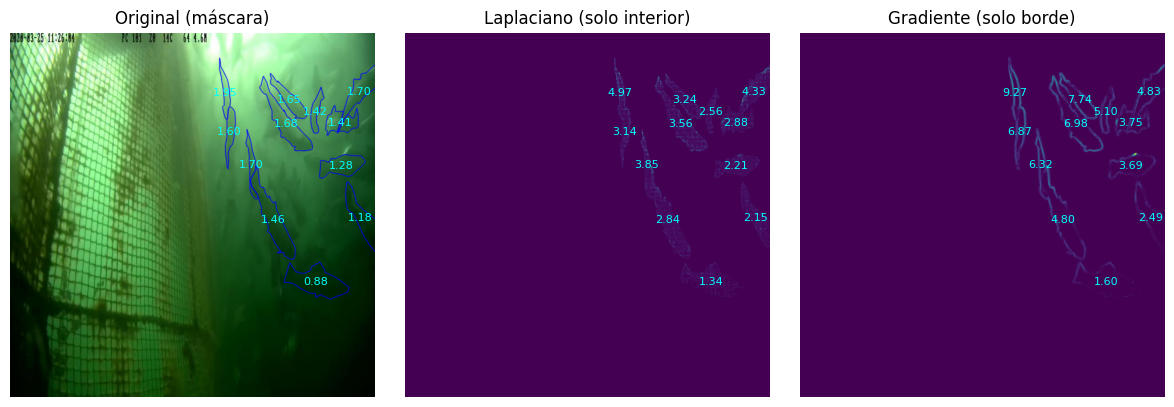

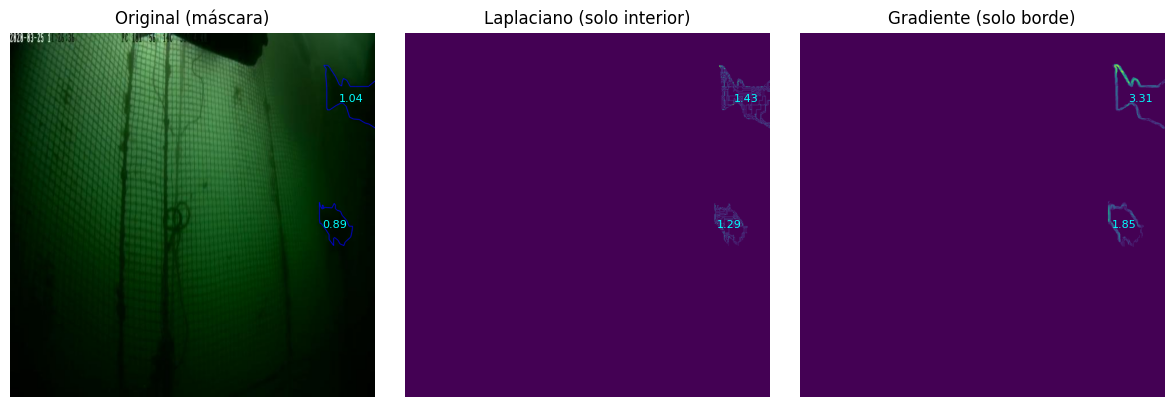

In [11]:
import pickle
with open("list_imagenes_ejemplo.pkl", "rb") as f:
    image_list = pickle.load(f)

images_folder = "salmones/images"
labels_folder = "salmones/labels"
ksize1 = -1  # Sobel
ksize2 = None  # Laplaciano
ksize3 = 5  # Promedio borde
peso_borde = 0.3
peso_interior = 0.7

for image_name in image_list:
    img_path = os.path.join(images_folder, image_name)
    lbl_path = os.path.splitext(image_name)[0] + ".txt"
    lbl_path = os.path.join(labels_folder, lbl_path)

    img = cv2.imread(img_path)
    segs = load_yolo_segmentation(lbl_path)

    polygons, nitidez_interna, nitidez_borde, lap_db, grad_mag, band_bordes = compute_metrics(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), segs, ksize1=ksize1, ksize2=ksize2, ksize3=ksize3)
    plot_results(img, polygons, nitidez_interna, nitidez_borde, lap_db, grad_mag, band_bordes, peso_borde, peso_interior)

## Visualizar filtrado uwu

In [8]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from main import load_yolo_segmentation, scale_polygon, calc_metrics_single_polygon, get_sobel_kernel, calcular_escala_kernel, desicion_making

INVALID_COLOR = (128, 128, 128)  # Gris para métricas inválidas
ROJO = (0, 0, 255)
AZUL = (255, 0, 0)
AMARILLO = (0, 255, 255)
VERDE = (0, 255, 0)
MAGENTA = (255, 0, 255)
NEGRO = (0, 0, 0)
BLANCO = (255, 255, 255)
NARANJA = (0, 165, 255)

def select_color(score):
    if score == 0:  # Pez Grande
        return AZUL
    elif score == 1:  # Pez mediano
        return AMARILLO
    elif score == 2:  # Pez pequeño
        return ROJO
    elif score == 3:  # Pez borroso
        return INVALID_COLOR
    else:
        return NEGRO

def draw_polygons(image, segmentations, use_color=None, thickness=2):
    """
    Dibuja polígonos sobre una imagen a partir de una lista de segmentaciones.

    Args:
        image: Imagen en formato BGR (numpy array).
        segmentations: Lista de diccionarios con 'points' (coordenadas normalizadas).
        color: Color de los polígonos en formato BGR (default: verde).
        thickness: Grosor de las líneas de los polígonos.

    Returns:
        Imagen con los polígonos dibujados.
    """
    img_copy = image.copy()
    for seg in segmentations:
        points = seg["points"]
        if use_color is not None:
            color = use_color
        else:
            color = select_color(seg["class_id"])
        # Convertir coordenadas normalizadas a píxeles
        points_px = [(int(x * img_copy.shape[1]), int(y * img_copy.shape[0])) for x, y in points]
        points_array = np.array(points_px, np.int32).reshape((-1, 1, 2))
        cv2.polylines(img_copy, [points_array], isClosed=True, color=color, thickness=thickness)
    return img_copy

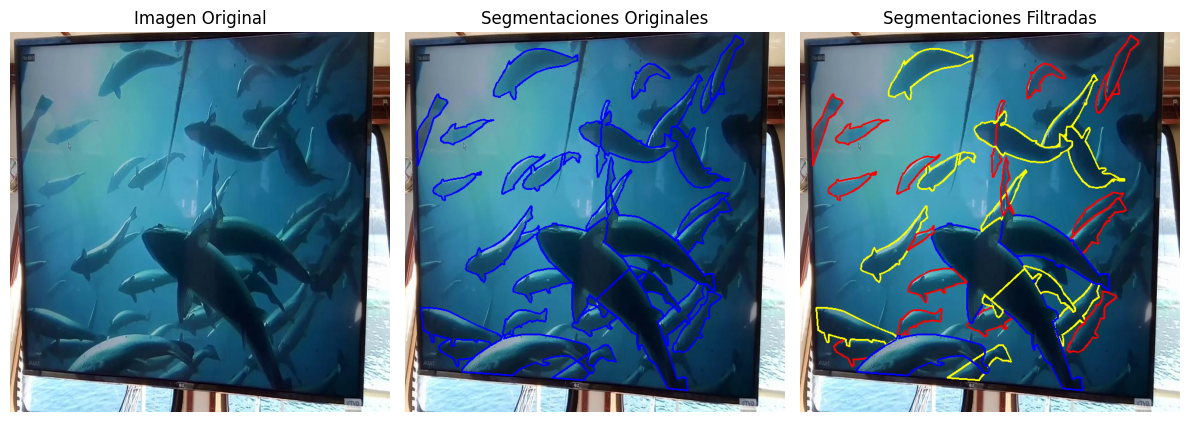

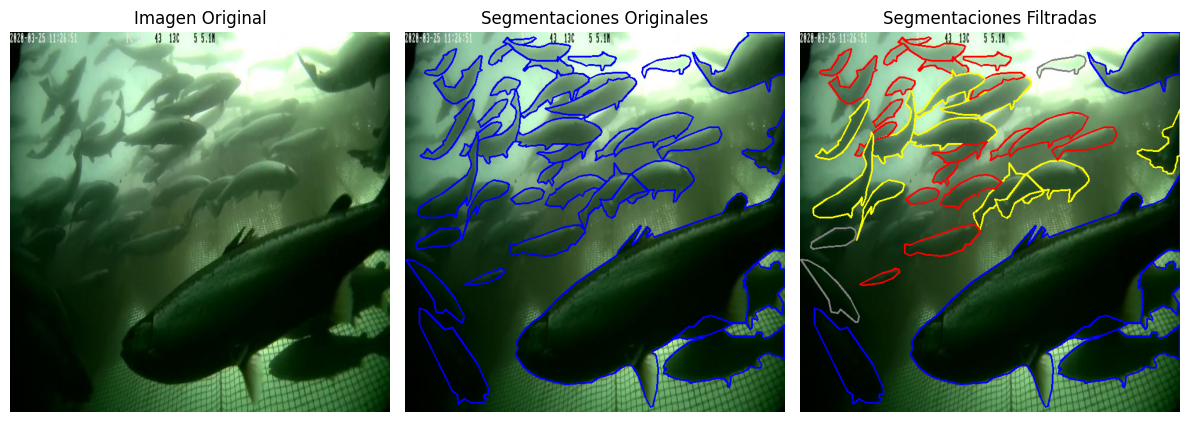

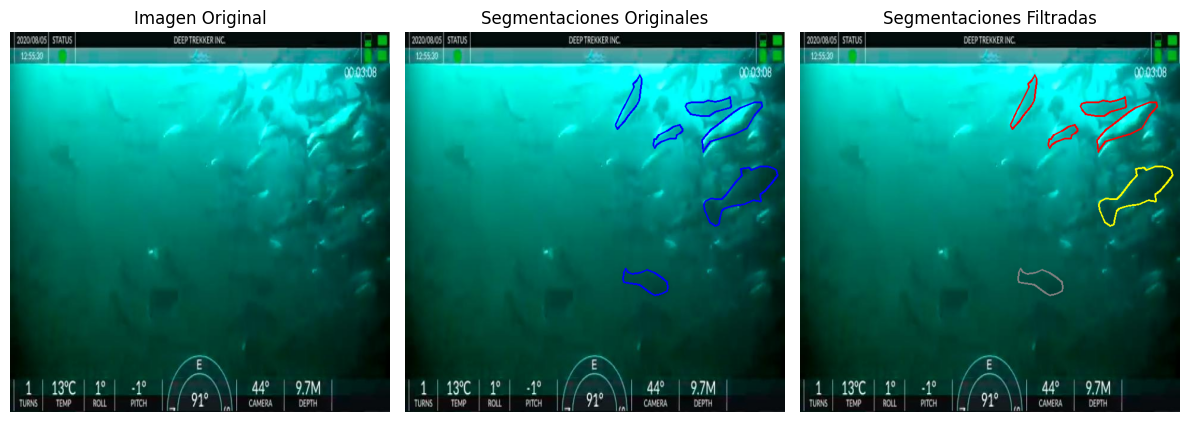

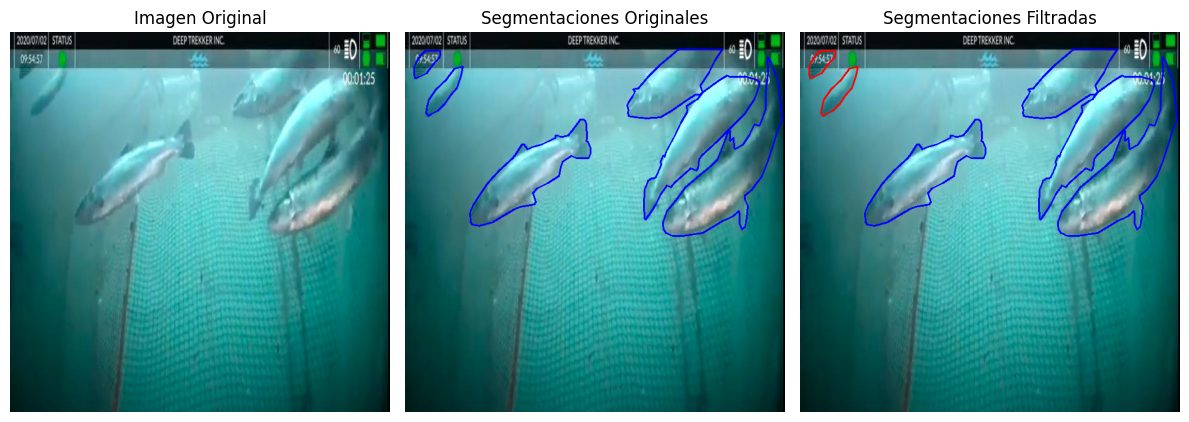

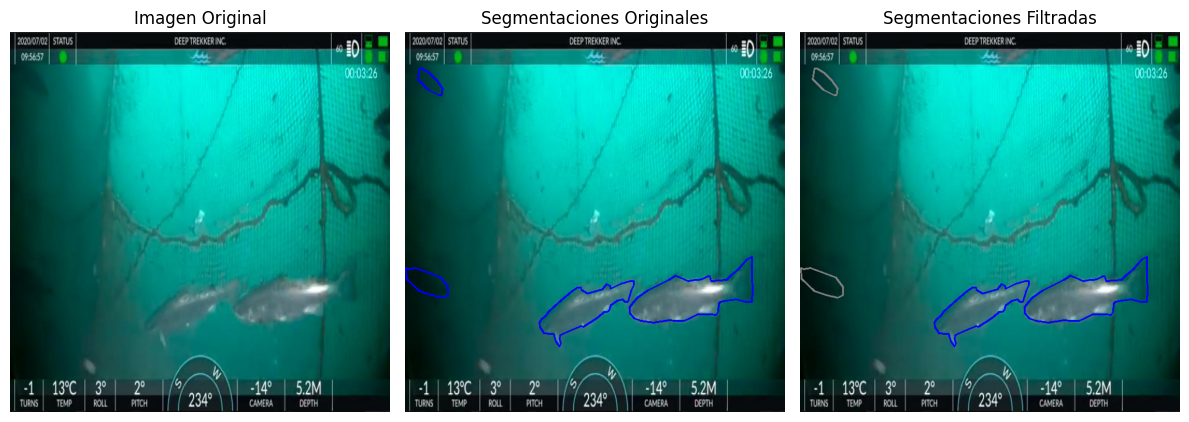

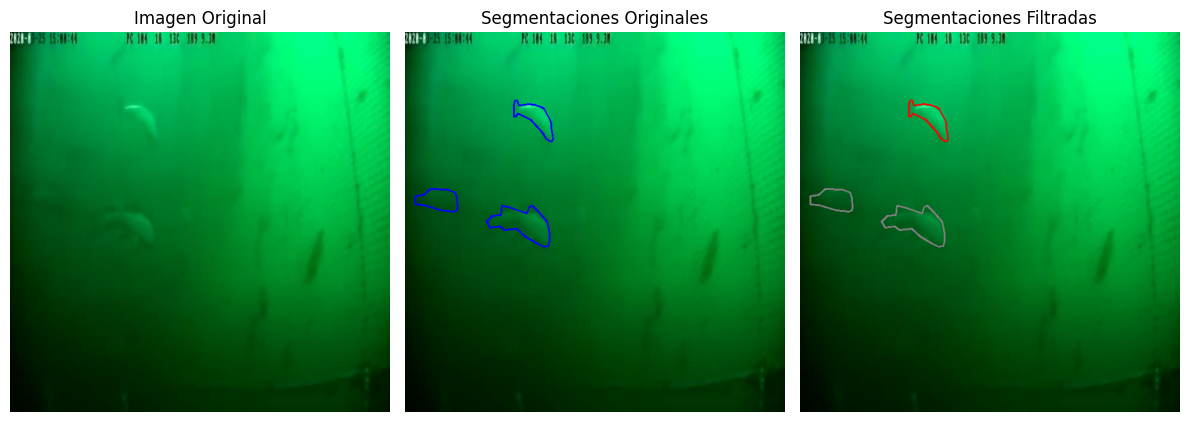

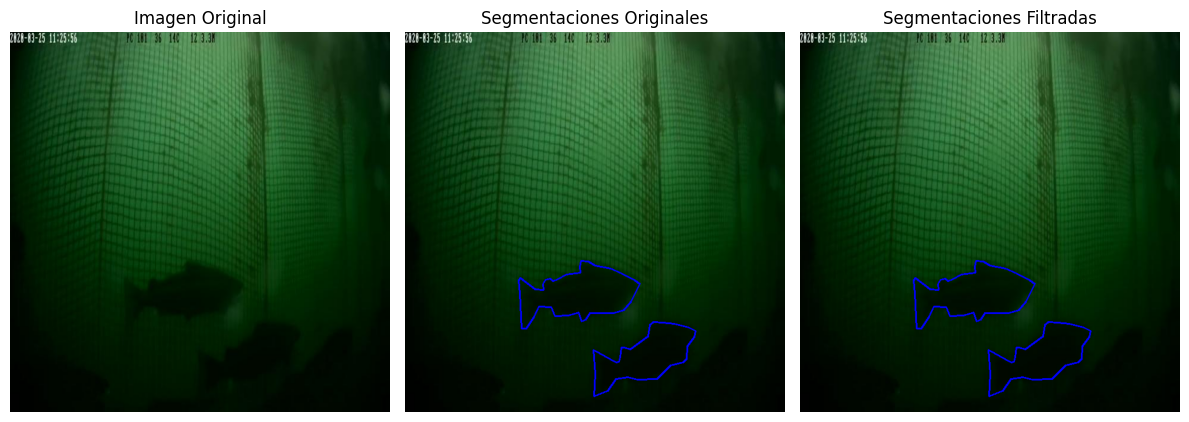

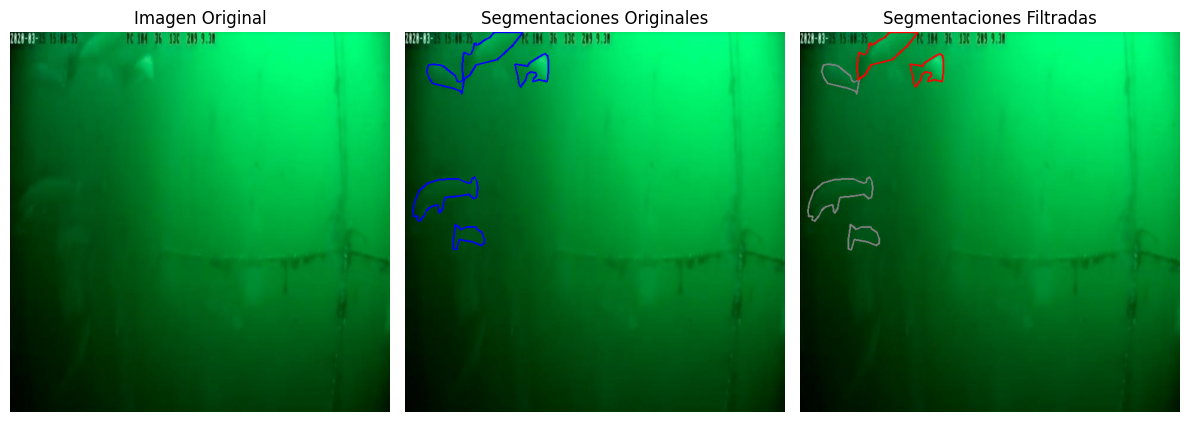

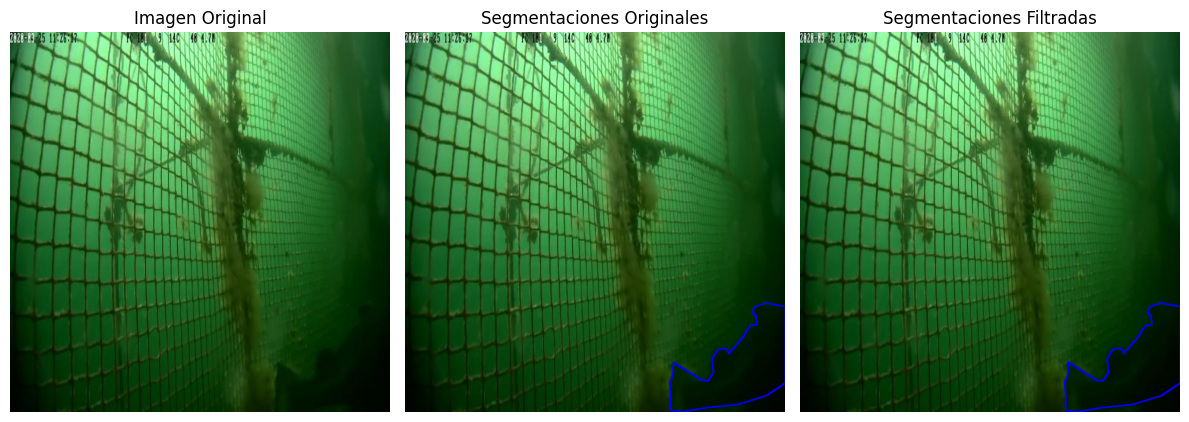

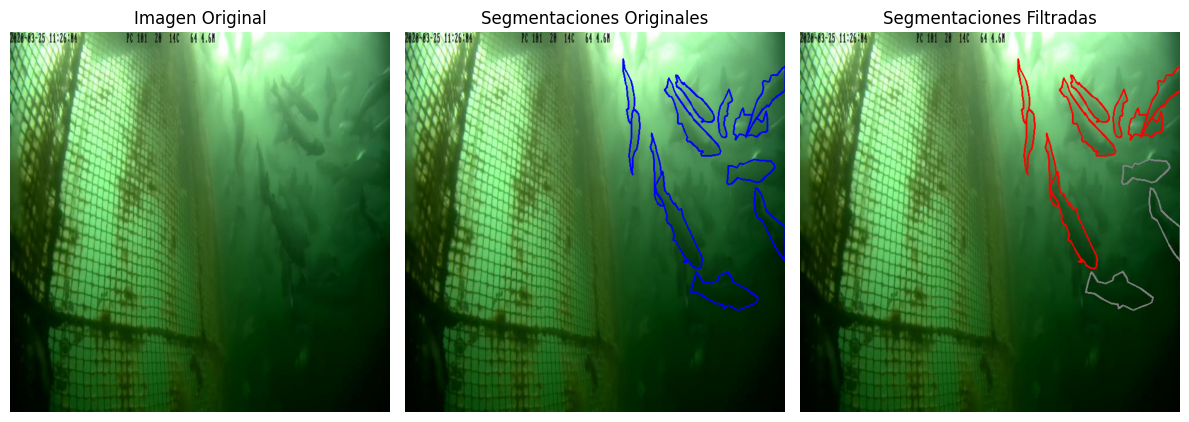

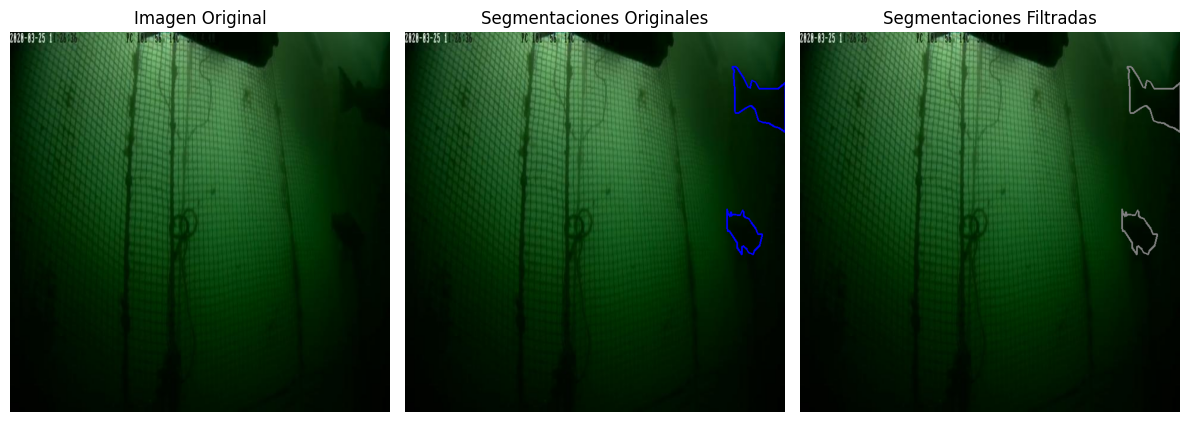

In [9]:
with open("list_imagenes_ejemplo.pkl", "rb") as f:
    image_list = pickle.load(f)

images_folder = "salmones/images"
labels_folder = "salmones/labels"
metrics_list = ["area", "perimeter", "aspect_ratio", "nitidez"]
peso_borde = 0.15
ksize_sobel = -1
ksize_band = 5

for image_name in image_list:
    label = os.path.splitext(image_name)[0]
    label_path = os.path.join(labels_folder, f"{label}.txt")
    image_path = os.path.join(images_folder, image_name)

    # Cargar imagen
    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]

    # En caso de querer calcularse la nitidez, es necesario pasar la imagen original.
    if image is not None:
        # Convertir la imagen a escala de grises
        gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Calcular gradiente y laplaciano de la imagen
        sob_kernel = get_sobel_kernel(ksize_sobel)
        sob_factor = calcular_escala_kernel(sob_kernel)
        gx = cv2.Sobel(gris, cv2.CV_32F, 1, 0, ksize=ksize_sobel, scale=sob_factor)
        gy = cv2.Sobel(gris, cv2.CV_32F, 0, 1, ksize=ksize_sobel, scale=sob_factor)
        grad_mag = np.sqrt(gx**2 + gy**2)
        laplaciano = cv2.Laplacian(gris, cv2.CV_32F)
        gradientes = grad_mag, laplaciano
    else:
        gradientes = None

    # Cargar polígonos
    segmentations_of_file = load_yolo_segmentation(label_path)
    filtered_labels = []
    # filtered_labels = procesar_poligonos(segmentations, img_height, img_width)

    for seg in segmentations_of_file:
        points = seg["points"]
        polygon = scale_polygon(points, img_width, img_height)
        metricas = calc_metrics_single_polygon(polygon, metrics_list, peso_borde, ksize_band, gradientes)
        score = desicion_making(metricas)
        filtered_labels.append({"class_id": score, "points": points})

    # Dibujar segmentaciones originales (verde) y filtradas (rojo)
    image_with_original = draw_polygons(image, segmentations_of_file, use_color=(255, 0, 0))
    image_with_filtered = draw_polygons(image, filtered_labels)

    # Convertir de BGR a RGB para matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_with_original_rgb = cv2.cvtColor(image_with_original, cv2.COLOR_BGR2RGB)
    image_with_filtered_rgb = cv2.cvtColor(image_with_filtered, cv2.COLOR_BGR2RGB)

    # Visualizar las tres imágenes
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Imagen Original")
    axes[0].axis("off")
    axes[1].imshow(image_with_original_rgb)
    axes[1].set_title("Segmentaciones Originales")
    axes[1].axis("off")
    axes[2].imshow(image_with_filtered_rgb)
    axes[2].set_title("Segmentaciones Filtradas")
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()